In [14]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString
from scipy.spatial import distance

### Load London Underground shapefile data

In [15]:
#read in the data using geopandas
stations = gpd.read_file('data/raw/tfl/tfl_stations.json')
lines = gpd.read_file('data/raw/tfl/tfl_lines.json')

In [16]:
#project data to British National Grid
#we do this so we can work in meters
stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)

### Clean station names

Simplify names using RegEx make the names consistent. For stations with multiple rows, set the coordinate of these stations to the mean values of the coordinates of the rest

In [17]:
#get all station names, put in a dict together with their id
station_names = {row.id: row['name'] for i, row in stations.iterrows()}

In [18]:
#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    #combine bank and monument in TfL numbat
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\shaun\AppData\Local\Temp\ipykernel_12204\4093908911.py:5: SyntaxWarning: invalid escape sequence '\s'
  cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)


**Change position of station to mean of all station with the same name**

In [19]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

In [20]:
#set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))

### Clean line names

One geometry can represent multiple lines. Let's work each line seperately

In [25]:
#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)])
line_names = list(set([item for sublist in line_names for item in sublist]))
line_names

['Bakerloo',
 'DLR',
 'Jubilee',
 'London Overground',
 'Victoria',
 'Waterloo & City',
 'Piccadilly',
 'District',
 'Emirates Air Line',
 'CR2',
 'Hammersmith & City',
 'Metropolitan',
 'Circle',
 'Elizabeth',
 'Tramlink',
 'Central',
 'Thameslink 6tph line',
 'Northern']

In [22]:
#We can see that east london line is incomplete
#digging into this however we notice that it's because east london is actually part of the overground
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')

# Change Crossrail to Elizabeth, exact match replacement
lines.lines = lines.lines.str.replace('Crossrail', 'Elizabeth')
stations.lines = stations.lines.str.replace('Crossrail', 'Elizabeth')

# Change TfL Rail to Elizabeth, exact match replacement
lines.lines = lines.lines.str.replace('TfL Rail', 'Elizabeth')
stations.lines = stations.lines.str.replace('TfL Rail', 'Elizabeth')

# Change TfL Rail to Elizabeth, exact match replacement
lines.lines = lines.lines.str.replace('Elizabeth 2', 'CR2')
stations.lines = stations.lines.str.replace('Elizabeth 2', 'CR2')


In [ ]:
#get all line types as a list and subset geoms by lines after change
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)])
line_names = list(set([item for sublist in line_names for item in sublist]))
line_names

In [26]:
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'CR2', 'Emirates Air Line', 'Tramlink', 'TfL Rail']

Bakerloo


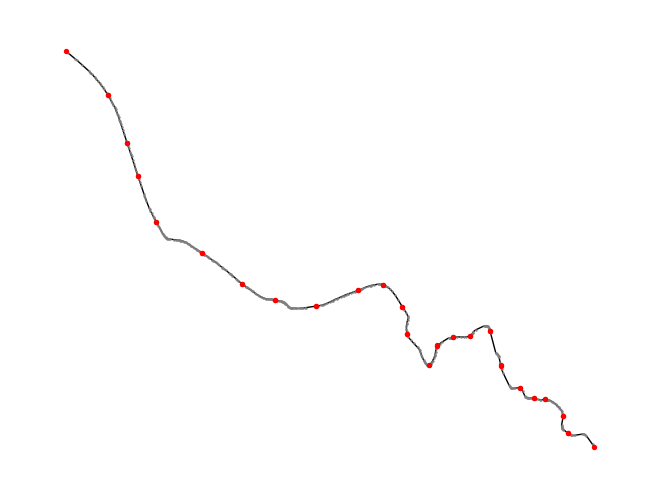

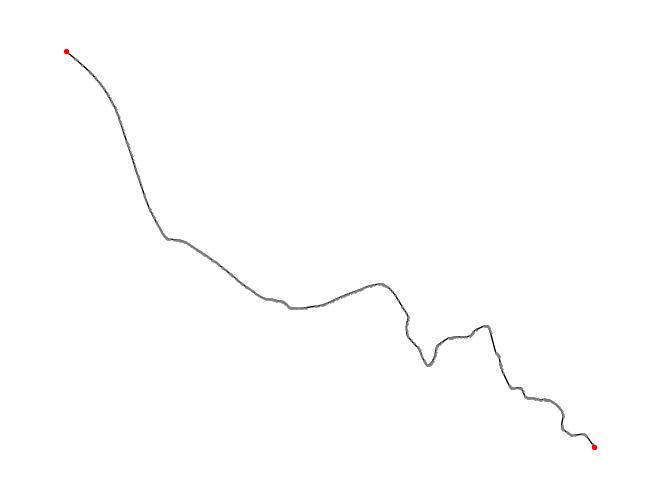

1
DLR


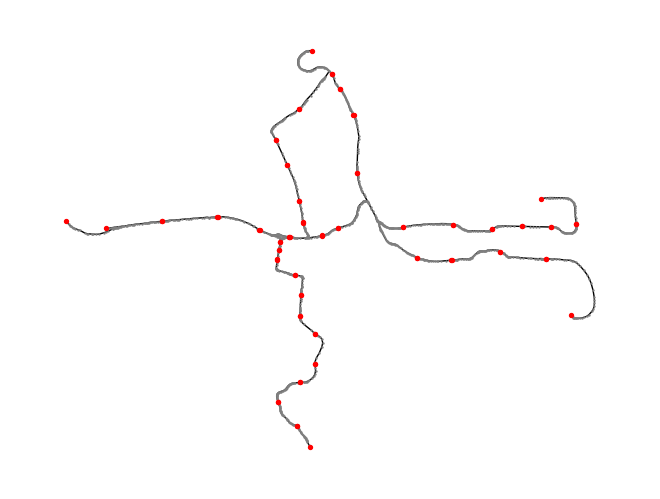

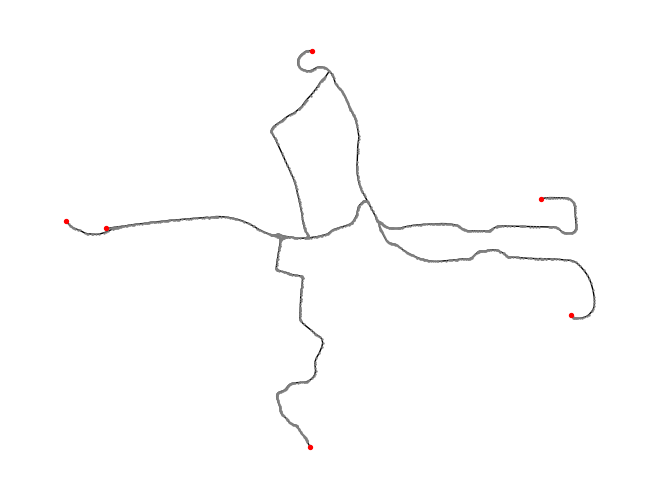

1
Jubilee


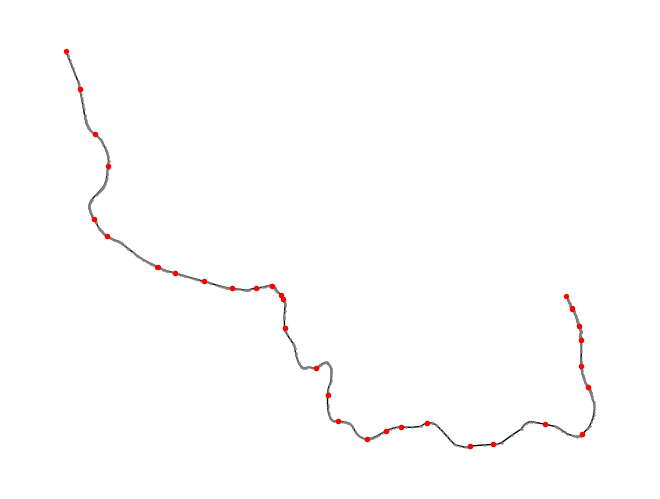

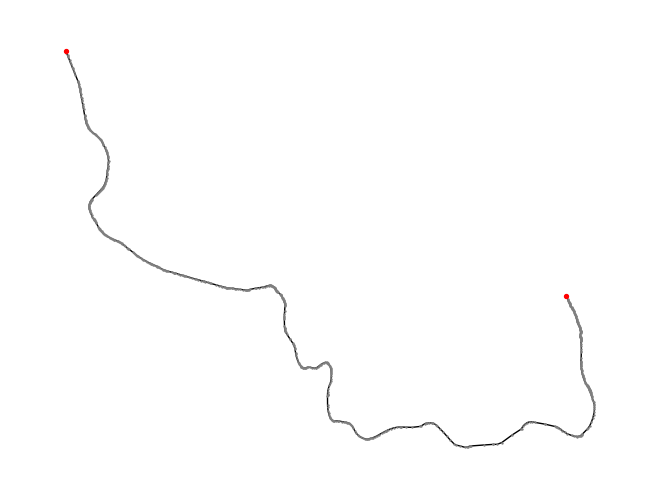

1
London Overground


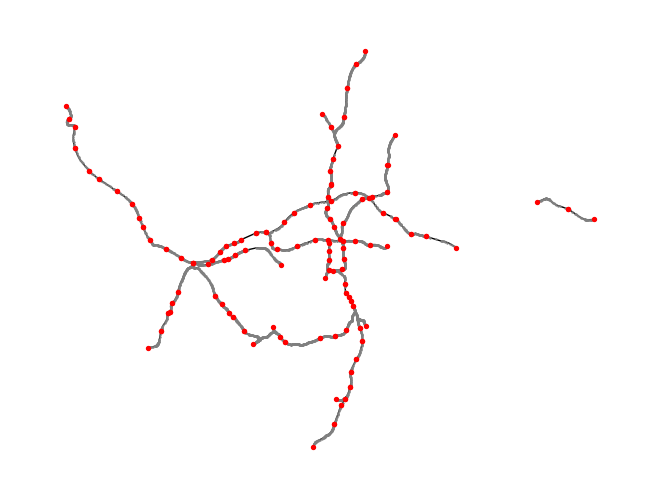

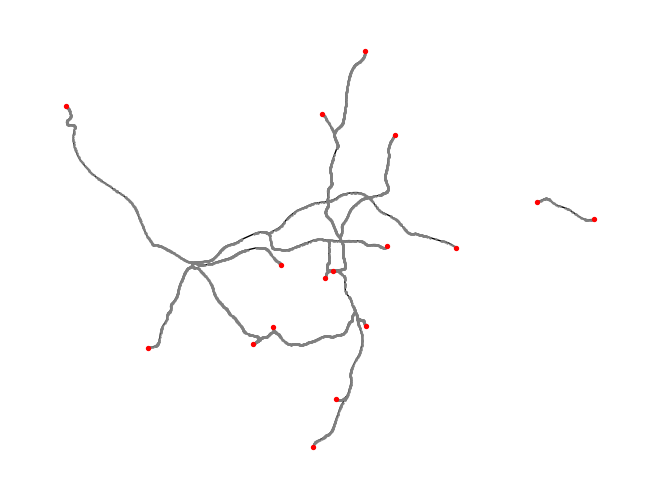

3
Victoria


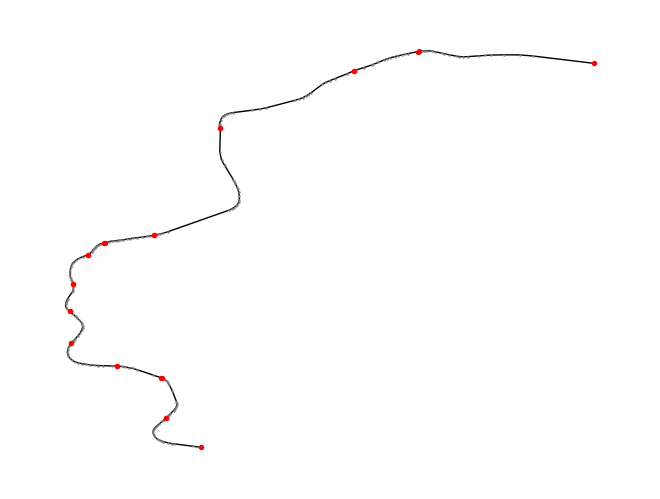

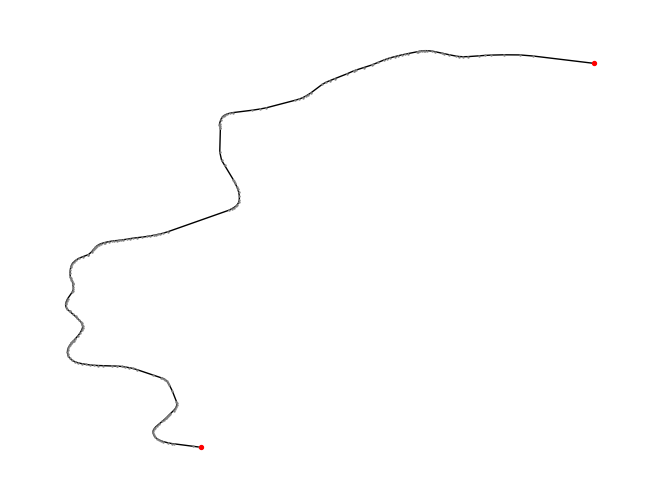

1
Waterloo & City


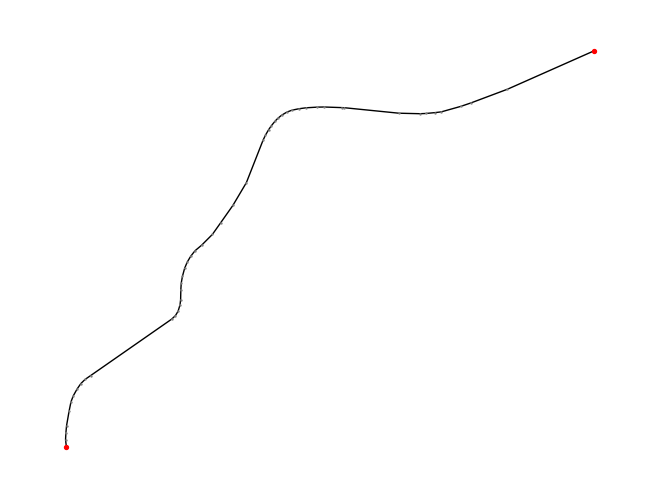

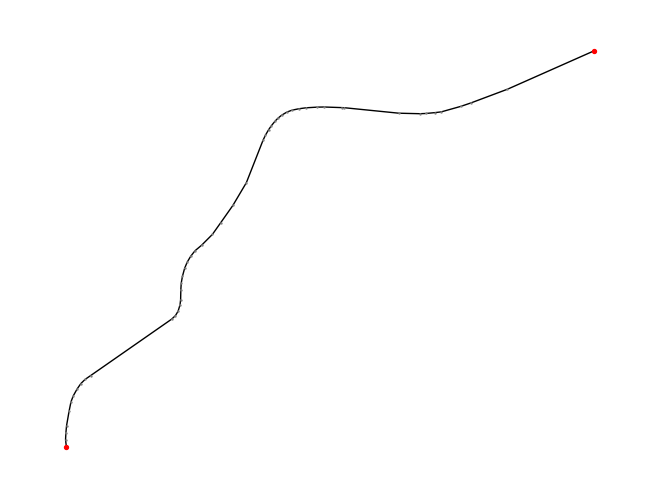

1
Piccadilly


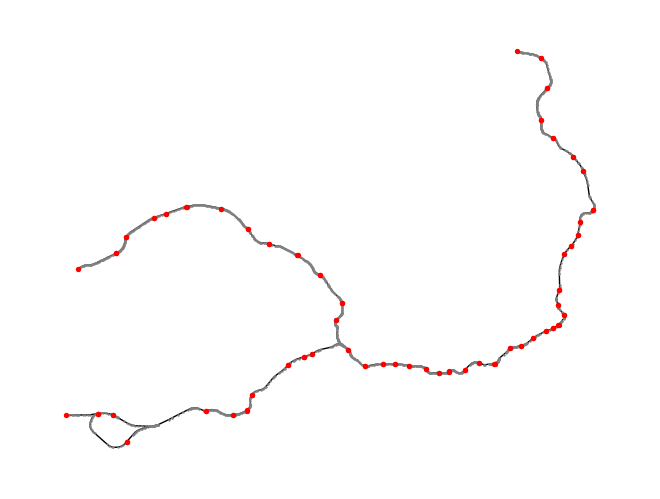

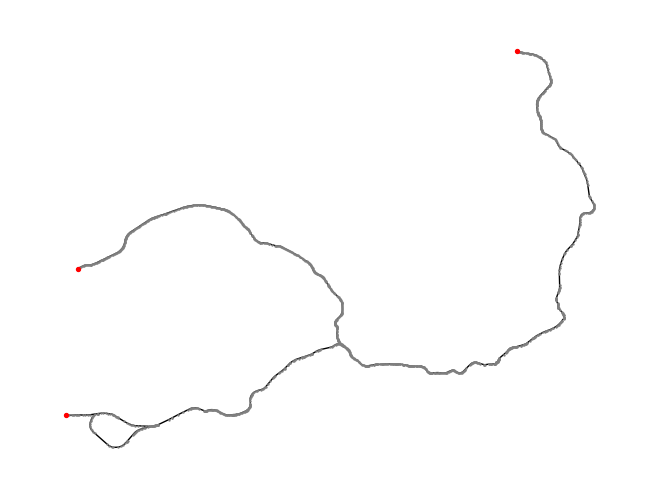

1
District


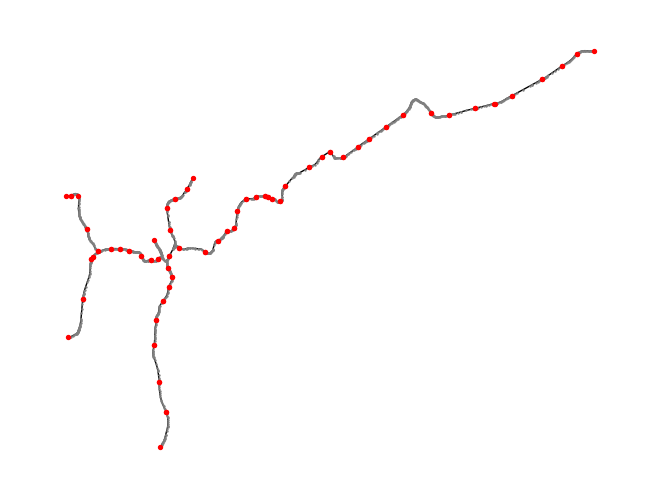

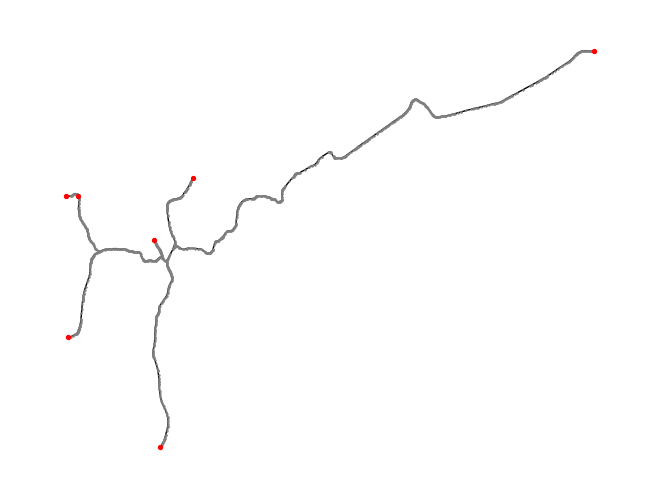

1
Hammersmith & City


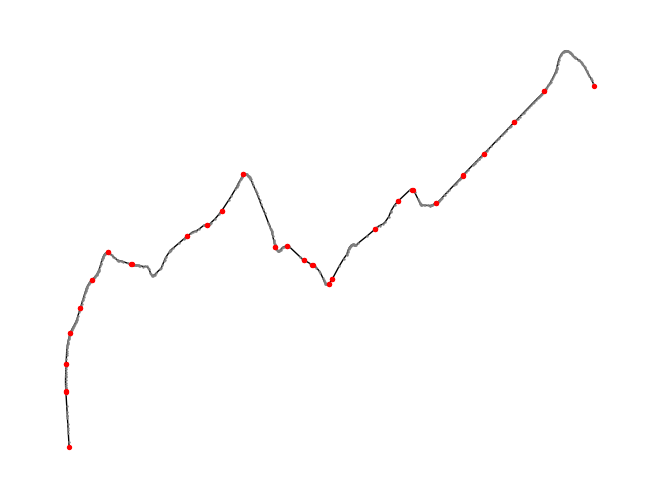

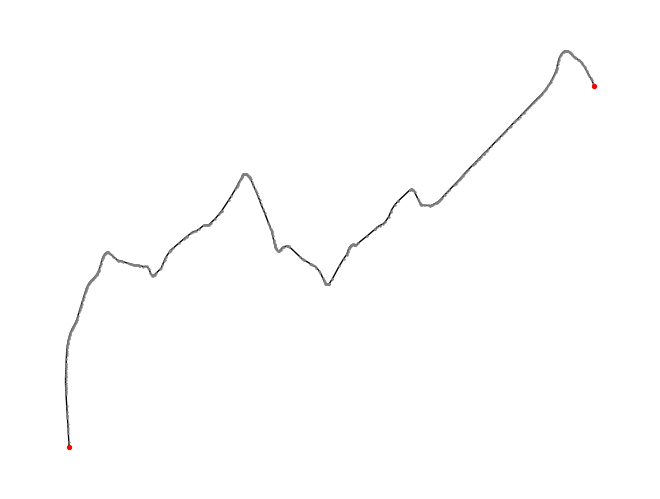

1
Metropolitan


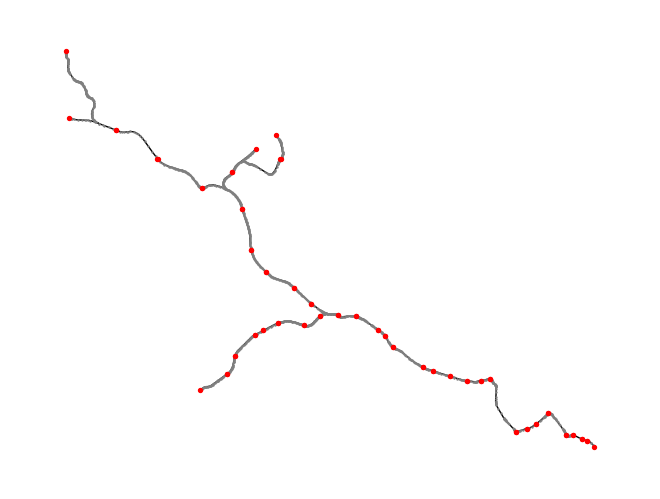

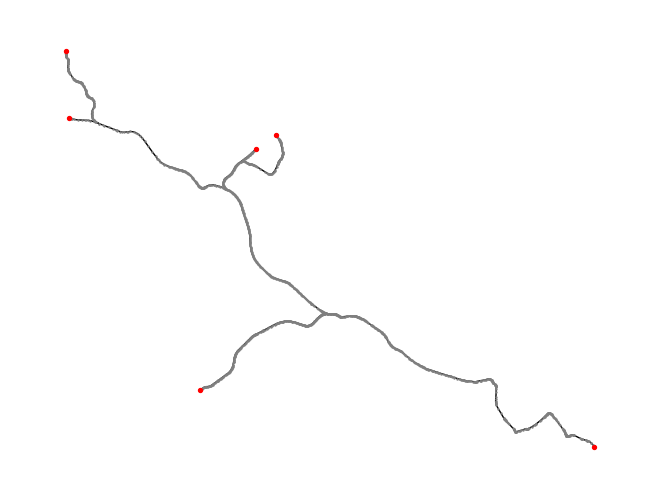

1
Circle


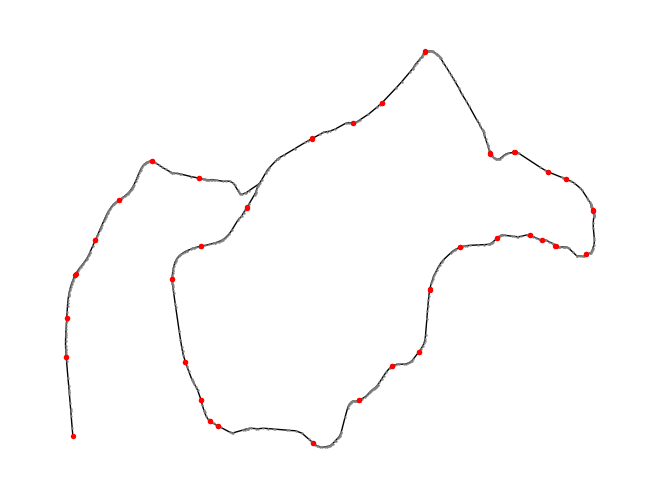

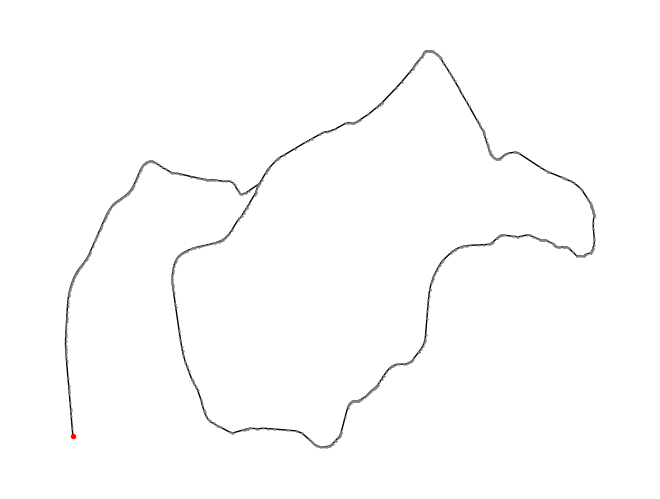

1
Elizabeth


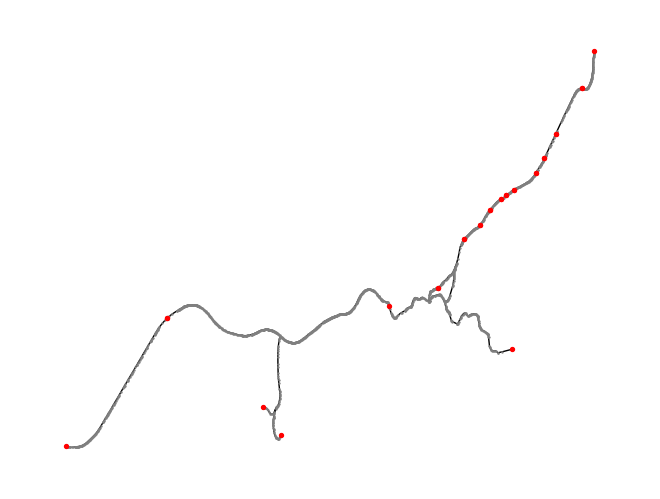

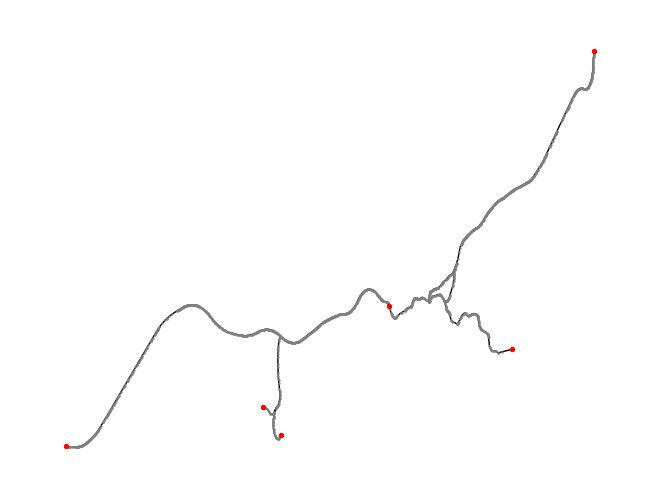

1
Central


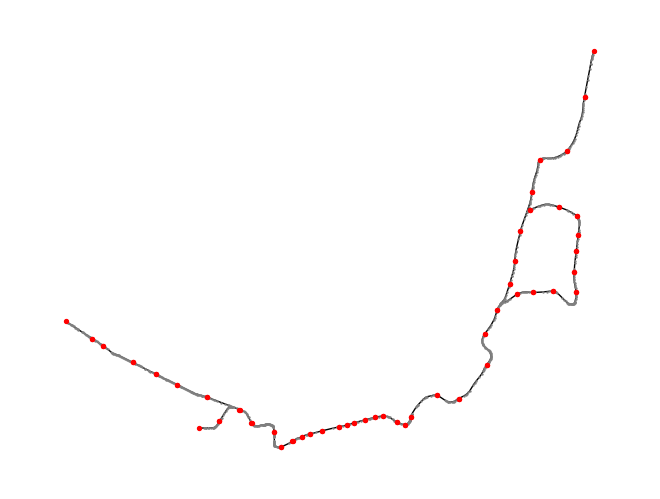

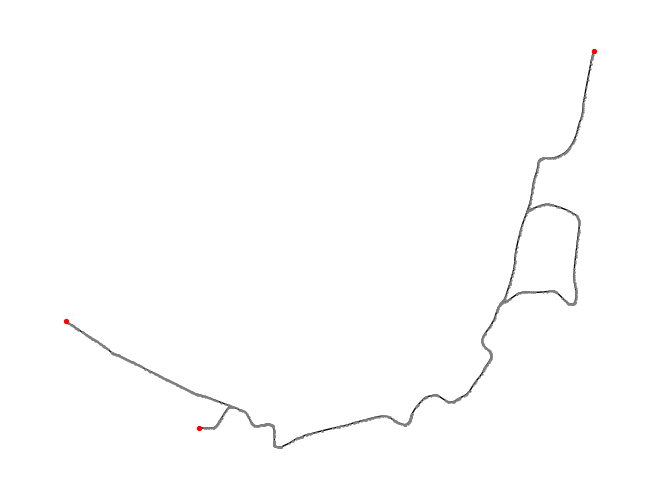

1
Northern


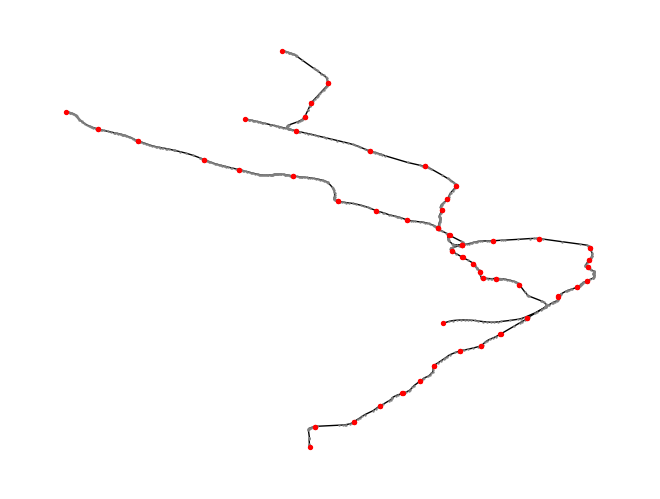

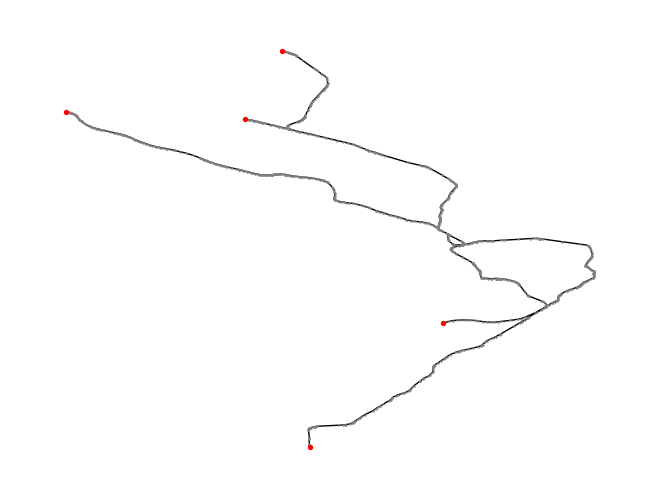

1


In [27]:
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G


In [28]:
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })

In [29]:
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs

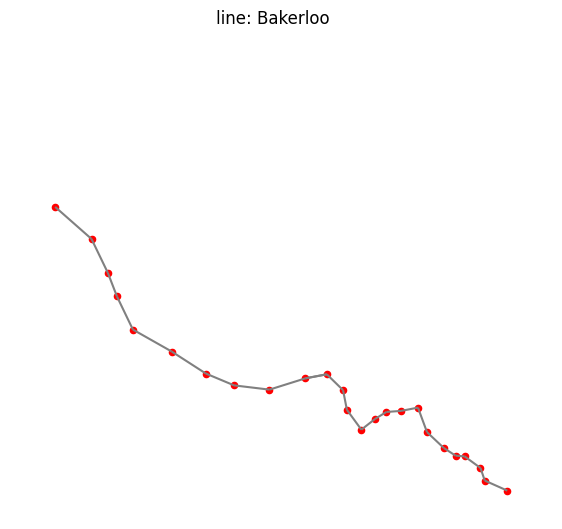

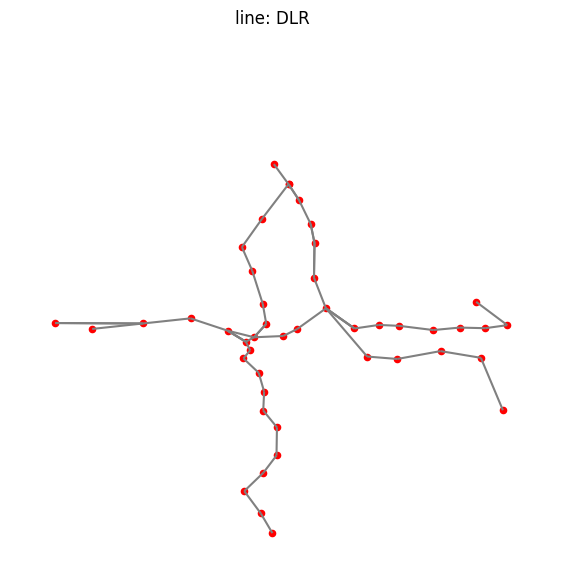

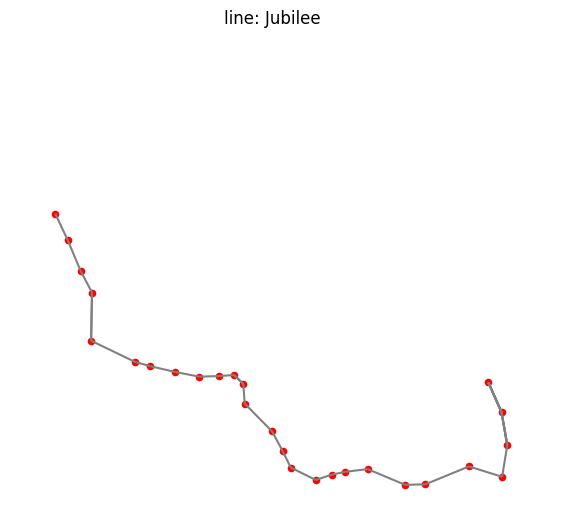

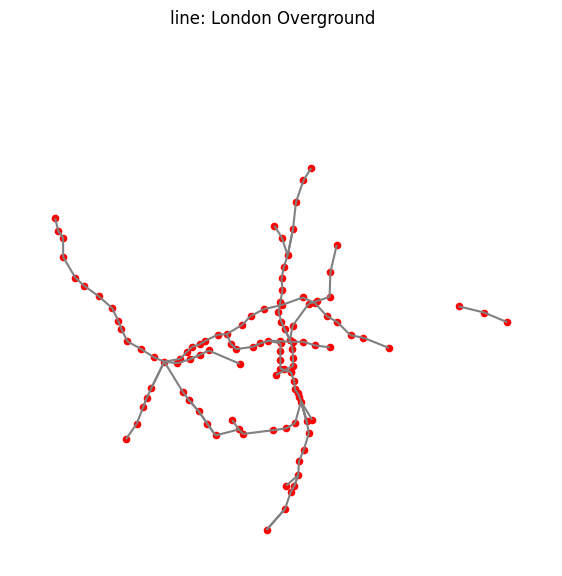

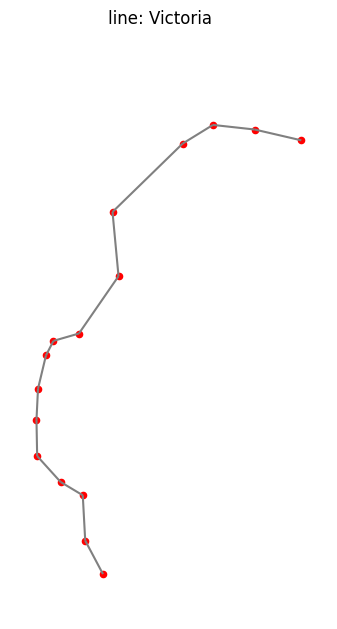

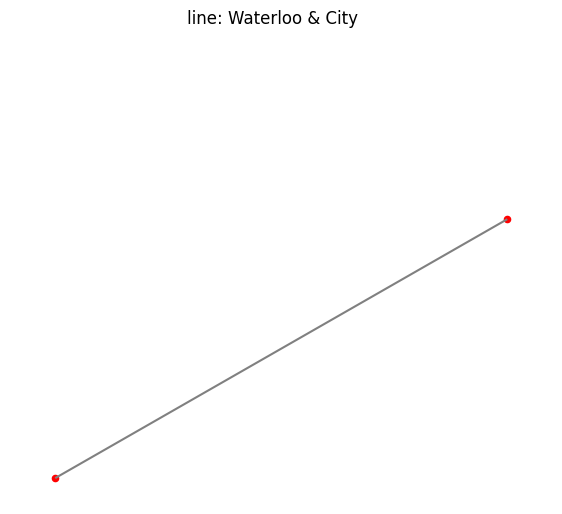

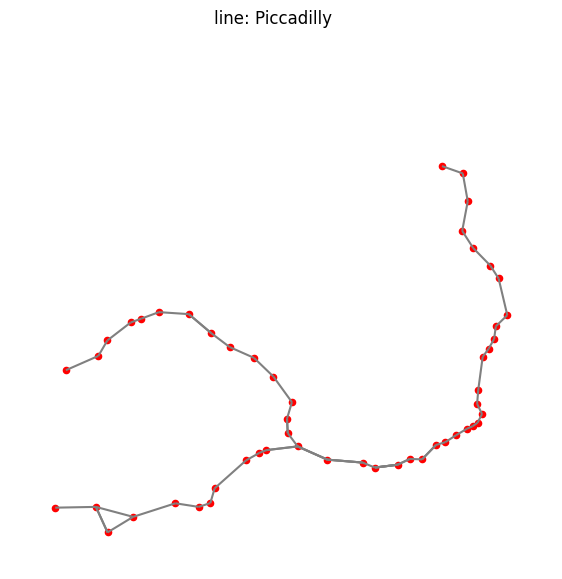

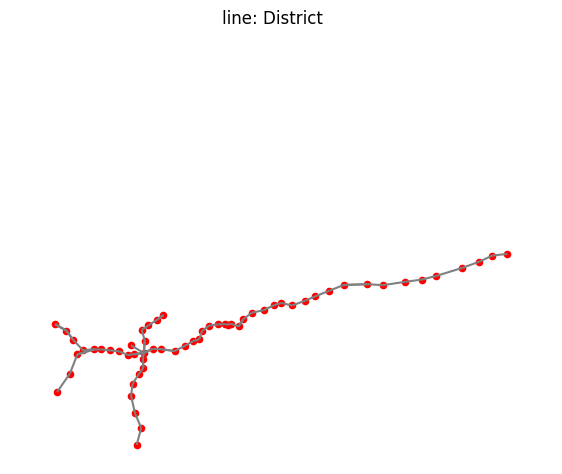

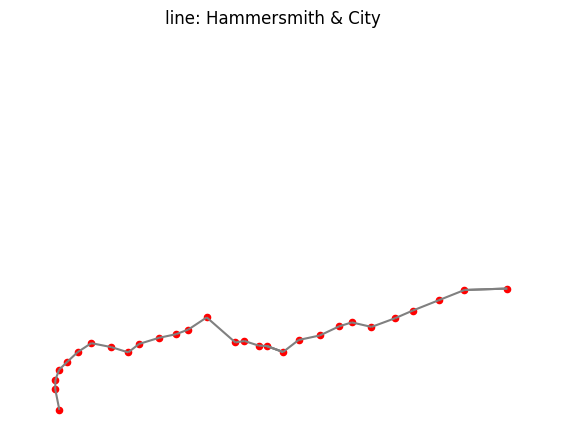

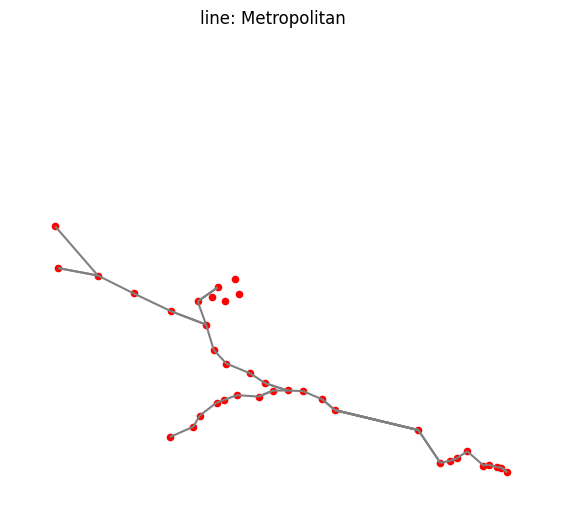

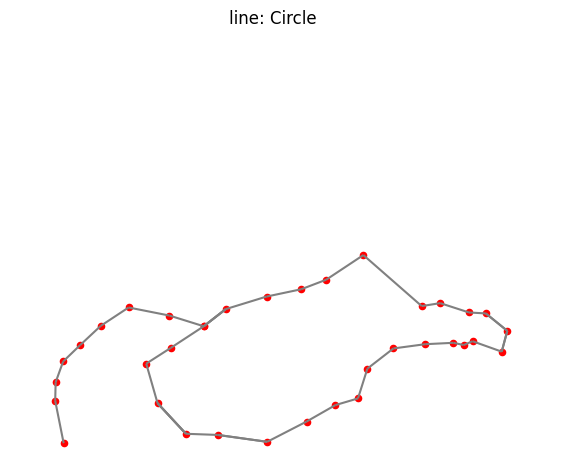

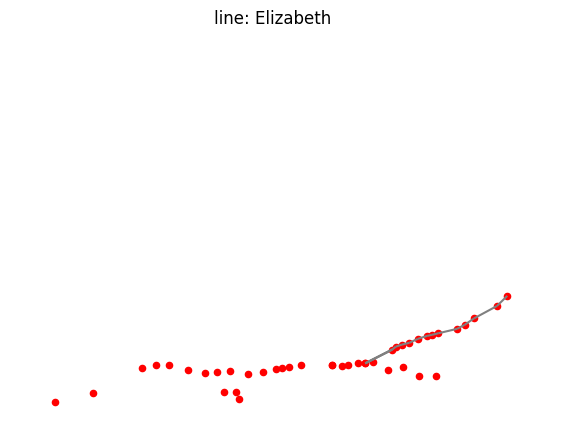

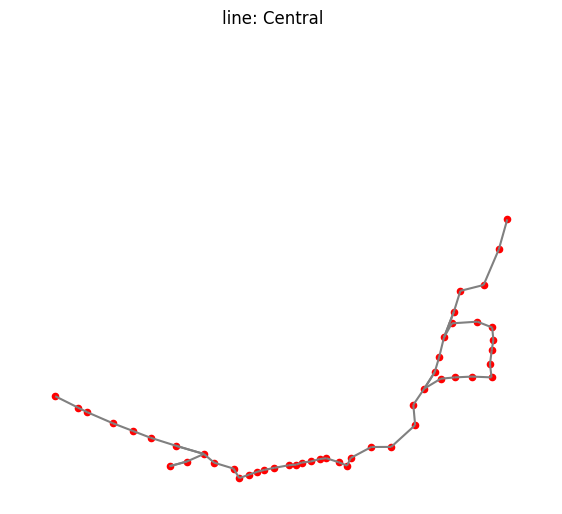

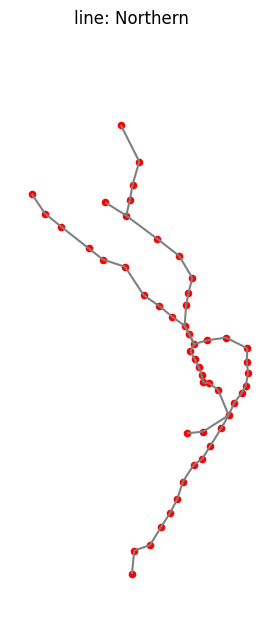

In [30]:
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line_name}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    
    base = temp_lines.plot(ax=ax, color='grey')
    temp_stations.plot(ax=base, markersize=20, color='red')
    plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

In [31]:
#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length

In [32]:
#let's replace the ids with the actual name
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)

In [33]:
edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

In [34]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

{'DLR', 'Jubilee', 'London Overground', 'Victoria', 'Waterloo & City', 'Piccadilly', 'District', 'Central', 'Hammersmith & City', 'Metropolitan', 'Circle', 'Elizabeth', 'Bakerloo', 'Northern'}


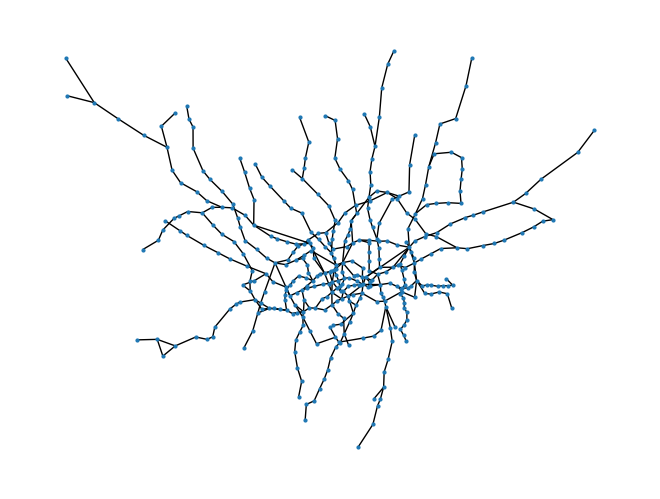

In [35]:
#let's plot
#notice that even though we created the real geometries, the graph still plots just straight line
#this is because networkx doesn't have a concept of a edge geometry
#however this is ok, since we only need the distance as weights, and that is already an attribute in our graph
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

In [36]:
#save position to graph
nx.set_node_attributes(G, pos, 'coords')

# Centrality Measures

Use degree, betweenness, closeness (topological) and katz 

In [37]:
# Degree centrality is a measure of the number of edges that a node has in the network. 
# It is a measure of how well connected a node is in the network.
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_london),'degree')

# Betweenness centrality is a measure of how many times a node lies on the shortest path between other nodes in the network.
bet_london_t=nx.betweenness_centrality(G, normalized=False)
nx.set_node_attributes(G,bet_london_t,'betweenness_t')

# Closeness centrality is a measure of how close a node is to all other nodes in the network.
clo_london_t=nx.closeness_centrality(G)
nx.set_node_attributes(G,clo_london_t,'closeness_t')

# PageRank is a measure of the importance of a node in the network.
pr_london_t=nx.pagerank(G)
nx.set_node_attributes(G,pr_london_t,'pagerank_t')

In [38]:
# Combine all the centrality measures into one dataframe
df = pd.DataFrame()
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df.set_index('station_name', inplace=True)  # Set 'station_name' as the index
df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))
df['closeness_t'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))
df['pagerank_t'] = pd.Series(nx.get_node_attributes(G, 'pagerank_t'))

df.reset_index(inplace=True)
df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:15]

,station_name,degree,betweenness_t,closeness_t,pagerank_t
81,Green Park,0.0150,17223.622114,0.114778,0.004381
32,Bank and Monument,0.0200,23181.058947,0.113572,0.006071
195,King's Cross St. Pancras,0.0175,20373.521465,0.113443,0.005828
80,Westminster,0.0100,16226.155916,0.112549,0.003052
22,Waterloo,0.0150,19464.882323,0.112265,0.004600
18,Oxford Circus,0.0150,4296.746032,0.111204,0.004301
82,Bond Street,0.0100,11298.961255,0.110988,0.003078
372,Angel,0.0050,5116.012518,0.110742,0.001873
286,Farringdon,0.0050,5116.012518,0.110742,0.001873
288,Moorgate,0.0100,10387.458369,0.110314,0.003252


In [39]:
# get geometry of the stations by station_name in df_sorted
df_sorted['geometry'] = df_sorted['station_name'].apply(lambda x: stations[stations['name'] == x].geometry.values[0])
df_sorted = gpd.GeoDataFrame(df_sorted, geometry='geometry')
df_sorted.crs = stations.crs
df_sorted

,station_name,degree,betweenness_t,closeness_t,pagerank_t,geometry
81,Green Park,0.0150,17223.622114,0.114778,0.004381,POINT (528968.086 180259.315)
32,Bank and Monument,0.0200,23181.058947,0.113572,0.006071,POINT (532821.106 180978.997)
195,King's Cross St. Pancras,0.0175,20373.521465,0.113443,0.005828,POINT (530299.567 182969.182)
80,Westminster,0.0100,16226.155916,0.112549,0.003052,POINT (530175.257 179658.048)
22,Waterloo,0.0150,19464.882323,0.112265,0.004600,POINT (530974.091 179921.099)
...,...,...,...,...,...,...
239,Heathrow Terminals 2 & 3,0.0075,399.000000,0.045096,0.003415,POINT (507403.979 175969.438)
237,Heathrow Terminal 4,0.0050,0.000000,0.045091,0.002275,POINT (508101.076 174443.751)
160,Watford High Street,0.0050,399.000000,0.044302,0.002887,POINT (511328.844 196058.638)
246,Heathrow Terminal 5,0.0025,0.000000,0.043155,0.001342,POINT (504965.941 175923.361)


In [41]:
# convert to hexagon resolution 9 using h3
import h3
import h3pandas

df = df_sorted.copy()
df.to_crs(epsg=4326, inplace=True)	
df = df.h3.geo_to_h3(resolution=8)
df = df.h3.h3_to_geo_boundary()
df.explore()


In [44]:
df.to_crs(epsg=27700, inplace=True)	

In [45]:
df.to_file(os.path.join('data','cleaned','rail_cent_h3_r8.gpkg'), driver='GPKG')